## Lab4 朴素贝叶斯分类器

- 姓名: 于洋淼
- 学号: 2113644
- 专业: 物联网工程

In [1]:
import numpy as np  
import pandas as pd
import matplotlib.pyplot as plt

## 初级要求

### 分层采样分割数据集

In [2]:
def stratified_shuffle_split(X, y, test_size=0.2, random_state=None):
    """
    分层采样，将数据集 X 和标签 y 按照类别比例划分为训练集和测试集。
    :param X: 特征矩阵，形状为 (n_samples, n_features)
    :param y: 标签数组，形状为 (n_samples,)
    :param test_size: 测试集占比，默认为 0.2
    :param random_state: 随机种子，默认为 None
    :return: X_train, X_test, y_train, y_test
    """
    # 获取类别数量和每个类别的索引
    unique, counts = np.unique(y, return_counts=True)
    indices = [np.where(y == label)[0] for label in unique]
    
    # 计算每个类别在测试集中的样本数量
    test_counts = np.ceil(counts * test_size).astype(int)
    
    # 初始化训练集和测试集的索引
    train_indices = []
    test_indices = []
    
    # 对每个类别进行分层采样
    for i, index in enumerate(indices):
        # 打乱索引
        np.random.seed(random_state)
        np.random.shuffle(index)
        
        # 划分训练集和测试集
        test_index = index[:test_counts[i]]
        train_index = index[test_counts[i]:]
        
        # 将索引添加到训练集和测试集中
        train_indices.append(train_index)
        test_indices.append(test_index)
    
    # 将训练集和测试集的索引合并
    train_indices = np.concatenate(train_indices)
    test_indices = np.concatenate(test_indices)
    
    # 根据索引获取训练集和测试集
    X_train, y_train = X[train_indices], y[train_indices]
    X_test, y_test = X[test_indices], y[test_indices]
    
    return X_train, X_test, y_train, y_test


In [3]:
def load_data(file_path):
    # 读取数据
    data = pd.read_csv(file_path, header=None)
    # 将数据分为特征和标签
    X = data.iloc[:, 1:].values.astype(float)
    y = data.iloc[:, 0].values.astype(int)
    X_train, X_test, y_train, y_test = stratified_shuffle_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = load_data('wine.data')


### 朴素贝叶斯分类器

In [4]:
# 计算高斯分布的概率密度函数
def gaussian_pdf(x, mean, std):
    exponent = np.exp(-((x - mean) ** 2) / (2 * std ** 2))
    return (1 / (np.sqrt(2 * np.pi) * std)) * exponent

# 计算每个类别的先验概率
unique, counts = np.unique(y_train, return_counts=True)
priors = counts / len(y_train)

# 计算每个特征在每个类别下的均值和标准差
means = []
stds = []
for label in unique:
    X_label = X_train[y_train == label]
    means.append(np.mean(X_label, axis=0))
    stds.append(np.std(X_label, axis=0))

# 条件概率
pre_score1 = []
pre_score2 = []
pre_score3 = []

# 对于每个测试样本，计算其在每个类别下的条件概率
y_pred = []
for x in X_test:
    posteriors = []
    for i, label in enumerate(unique):
        prior = priors[i]
        likelihood = 1
        for j, feature in enumerate(x):
            mean = means[i][j]
            std = stds[i][j]
            likelihood *= gaussian_pdf(feature, mean, std)
        posterior = prior * likelihood
        posteriors.append(posterior)
    y_pred.append(unique[np.argmax(posteriors)])
    pre_score1.append(posteriors[0])
    pre_score2.append(posteriors[1])
    pre_score3.append(posteriors[2])

# 输出每个类别的准确率
accuracies = []
for label in unique:
    mask = (y_test == label)
    y_pred_label = [y_pred[i] for i in range(len(mask)) if mask[i]]
    y_test_label = [y_test[i] for i in range(len(mask)) if mask[i]]
    y_test_label = np.array(y_test_label)
    accuracy = (y_pred_label == y_test_label).mean()
    accuracies.append(accuracy)

# 每个类别的正确率
for i, label in enumerate(unique):
    print(f'Accuracy for class {label}: {accuracies[i]:.4f}')

# 平均正确率
accuracy = (y_pred == y_test).mean()
print(f'Average Accuracy: {accuracy:.4f}')

Accuracy for class 1: 0.9167
Accuracy for class 2: 1.0000
Accuracy for class 3: 1.0000
Average Accuracy: 0.9730


## 中级要求

### 混淆矩阵

In [5]:
def confusion_matrix(true_values, predicted_values):
    # 获取类别数量
    num_classes = max(max(true_values), max(predicted_values)) + 1

    # 初始化混淆矩阵
    matrix = [[0] * num_classes for _ in range(num_classes)]

    # 填充混淆矩阵
    for true, pred in zip(true_values, predicted_values):
        matrix[true][pred] += 1

    return matrix

### 精度、召回率、F1-score

In [6]:
cm = np.array(confusion_matrix(y_test, y_pred))
# 由于数据的label是1-3，所以混淆矩阵算出来的是4*4的，需要去掉第一行和第一列
cm = cm[1:, 1:]
print(cm.shape)
print('Confusion Matrix:')
print(cm)

# 计算精度、召回率、F值
tp = np.diag(cm)
fp = np.sum(cm, axis=0) - tp
fn = np.sum(cm, axis=1) - tp

precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * precision * recall / (precision + recall)

for i in range(len(recall)):
    print('class {}: recall: {:.4f}, precision: {:.4f}, f1_score: {:.4f}'.format(i+1, recall[i], precision[i], f1_score[i]))

(3, 3)
Confusion Matrix:
[[11  1  0]
 [ 0 15  0]
 [ 0  0 10]]
class 1: recall: 0.9167, precision: 1.0000, f1_score: 0.9565
class 2: recall: 1.0000, precision: 0.9375, f1_score: 0.9677
class 3: recall: 1.0000, precision: 1.0000, f1_score: 1.0000


## 高级要求

In [7]:
#绘制ROC曲线计算AUC值
def draw_roc(pre_scores, test_label):
    # 初始化假正例率和真正例率
    fpr = []
    tpr = []
    # 初始化AUC值
    auc = 0
     
    for i in np.argsort(pre_scores)[::-1]:
        threshold = pre_scores[i]
        if threshold == np.max(pre_scores):
            fpr.append(0)
            tpr.append(0)
            continue
        elif threshold == np.min(pre_scores):
            fpr.append(1)
            tpr.append(1)
            continue
        TP, FP, FN, TN = 0, 0, 0, 0
        for j in np.argsort(pre_scores)[::-1]:
            if pre_scores[j] >= threshold:
                if y_test[j] == test_label:
                    TP += 1
                else:
                    FP += 1
            else:
                if y_test[j] == test_label:
                    FN += 1
                else:
                    TN += 1
        fpr.append(FP / (FP + TN))
        tpr.append(TP / (TP + FN))
    
    # 计算AUC值
    for i in range(1, len(fpr)):
        auc += 0.5 * (fpr[i] - fpr[i - 1]) * (tpr[i] + tpr[i - 1])
        
    plt.title(f'class{test_label} ROC curve')
    plt.plot(fpr, tpr, label = 'ROC')
    plt.legend()
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.show()
    return auc

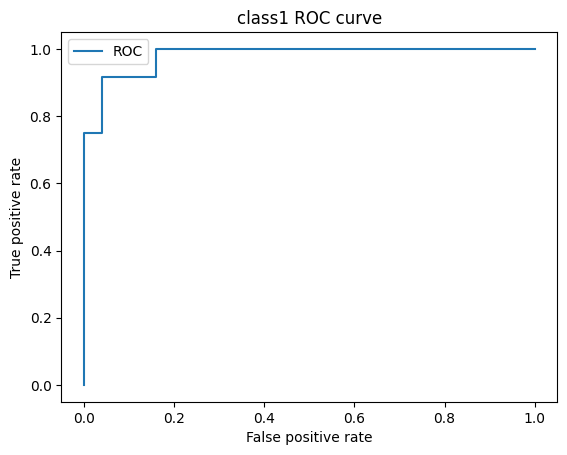

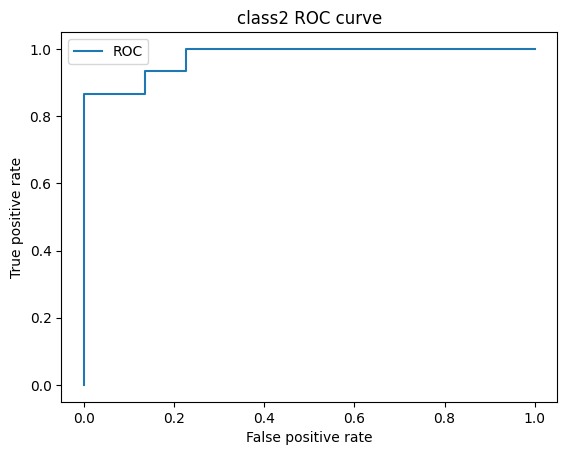

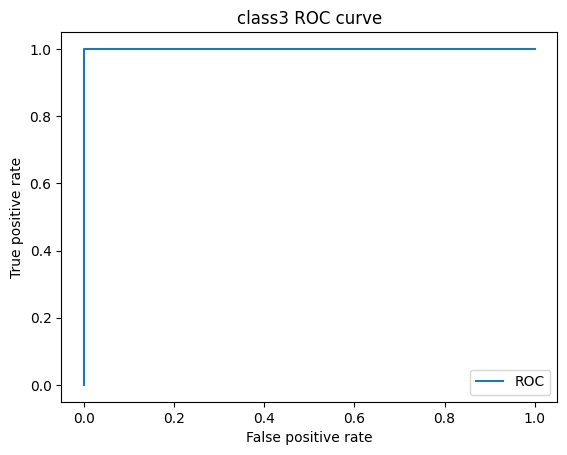

AUC for class 1: 0.9800
AUC for class 2: 0.9758
AUC for class 3: 1.0000


In [8]:
Auc = []

Auc.append(draw_roc(pre_score1, 1))
Auc.append(draw_roc(pre_score2, 2))
Auc.append(draw_roc(pre_score3, 3))

for i in range(len(Auc)):
    print(f'AUC for class {i+1}: {Auc[i]:.4f}')

## 扩展要求


#### ROC曲线的合理性：

1. **可视化权衡关系：** ROC曲线直观地展示了在不同阈值下真正例率（TPR）和假正例率（FPR）之间的权衡关系。这对于理解模型在不同工作点的表现很有帮助。

2. **不受类别不平衡的影响：** ROC曲线对于类别不平衡的问题更具有鲁棒性。在类别不平衡的情况下，精度等指标可能不是很敏感，而ROC曲线能够更全面地反映模型的性能。

#### AUC值的合理性：

1. **综合性能度量：** AUC值是ROC曲线下方的面积，代表了分类模型在所有可能阈值下的平均性能。这使得AUC成为一个综合性的性能度量，而不仅仅是在单一阈值下的性能。

2. **不受类别分布影响：** AUC值对于类别分布的改变不敏感，因此在应对类别不平衡问题时更为可靠。

### 综合考虑：

1. **适用性：** ROC曲线和AUC值适用于二分类问题，但在多分类问题中，需要对其进行适当修改或使用其他评价指标。

2. **权衡关系：** AUC值综合了不同阈值下的性能，但并不提供具体的阈值选择信息。所以需要根据具体任务和业务需求权衡模型对于不同类型错误的敏感性。

3. **与其他指标结合：** ROC曲线和AUC值通常与其他指标（如精确度、查准率等）一起使用，以全面评估模型性能。
